In [2]:
import arviz as az 
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import pymc_extras as pmx
import seaborn as sns

from pymc_marketing import clv

### Load data

In [3]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"

raw_data = pd.read_csv(url_cdnow)

### RFM aggregations

In [4]:
rfm_data = clv.rfm_summary(
    raw_data,
    customer_id_col="id",
    datetime_col="date",
    datetime_format="%Y%m%d",
    time_unit="W",
)

rfm_data.info()
rfm_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  2357 non-null   int64  
 1   frequency    2357 non-null   float64
 2   recency      2357 non-null   float64
 3   T            2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


,customer_id,frequency,recency,T
0,1,3.0,49.0,78.0
1,2,1.0,2.0,78.0
2,3,0.0,0.0,78.0
3,4,0.0,0.0,78.0
4,5,0.0,0.0,78.0


## ParetoNBDModel

### MAP fit

In [5]:
pnbd_map = clv.ParetoNBDModel(data=rfm_data)
pnbd_map.build_model()  # required for prior predictive checks
pnbd_map

Pareto/NBD
            alpha ~ Weibull(2, 10)
             beta ~ Weibull(2, 10)
                r ~ Weibull(2, 1)
                s ~ Weibull(2, 1)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

In [6]:
with pnbd_map.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, draws=1)

obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")[
    0
][0]

Sampling: [alpha, beta, r, recency_frequency, s]


In [7]:
pnbd_map.fit()
map_fit = pnbd_map.fit_summary()  # save for plotting later

obs_freq = pnbd_map.idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = pnbd_map.distribution_new_customer_recency_frequency(
    rfm_data,
    random_seed=42,
).sel(chain=0, draw=0, obs_var="frequency")


Output()

Sampling: [recency_frequency]


Output()

### DEMZ fit

In [8]:
pnbd_full = clv.ParetoNBDModel(data=rfm_data)
pnbd_full.fit(
    fit_method="demz", draws=3000, tune=2500, idata_kwargs={"log_likelihood": True}
)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, r, s]


Output()

Sampling 4 chains for 2_500 tune and 3_000 draw iterations (10_000 + 12_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

In [18]:
pnbd_full.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.614,1.050,13.668,17.537,0.036,0.026,862.0,996.0,1.0
beta,12.750,3.691,6.362,19.946,0.135,0.096,739.0,1323.0,1.0
r,0.619,0.046,0.542,0.712,0.002,0.001,855.0,898.0,1.0
s,0.431,0.060,0.320,0.544,0.002,0.001,824.0,1251.0,1.0


### Nutpie Fit

In [17]:
pnbd_nutpie = clv.ParetoNBDModel(data=rfm_data)
bgnbd_nutpie = clv.BetaGeoModel(data=rfm_data)

idata_nutpie = pnbd_nutpie.fit(fit_method = 'mcmc', nuts_sampler="nutpie")

/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


TypeError: The fgraph of ScalarLoop must be exclusively composed of scalar operations.

### ADVI fit

In [ ]:
pnbd_advi = clv.ParetoNBDModel(data=rfm_data)
pnbd_advi.fit(
    n=12500,
    fit_method="advi", 
    obj_n_mc=15,
    # obj_optimizer=pm.adagrad(learning_rate=100.),
    idata_kwargs={"log_likelihood": True}
)

Output()

Finished [100%]: Average Loss = 16,486


Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [39]:
pnbd_advi.fit_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.547,0.567,14.514,16.599,0.030,0.021,366.0,453.0,NaN
beta,12.531,1.160,10.681,14.933,0.054,0.038,458.0,372.0,NaN
r,0.612,0.019,0.575,0.646,0.001,0.001,448.0,353.0,NaN
s,0.429,0.021,0.396,0.472,0.001,0.001,502.0,446.0,NaN


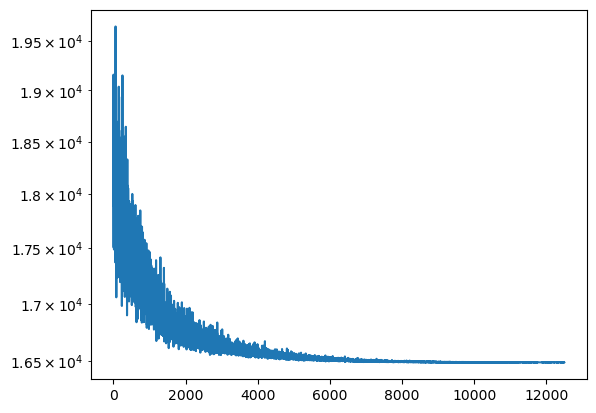

In [ ]:
sns.lineplot(pnbd_advi.approx.hist, )
plt.yscale('log')

### Full-rank fit

In [42]:
pnbd_fullrank = clv.ParetoNBDModel(data=rfm_data)
pnbd_fullrank.fit(
    fit_method="fullrank_advi", 
    obj_n_mc=5,
    idata_kwargs={"log_likelihood": True}
)

Output()

Finished [100%]: Average Loss = 16,530


Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [43]:
pnbd_fullrank.fit_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.207,5.127,6.969,26.097,0.220,0.159,552.0,428.0,NaN
beta,14.941,10.196,2.099,33.381,0.503,0.394,467.0,363.0,NaN
r,0.592,0.209,0.253,0.973,0.010,0.007,391.0,409.0,NaN
s,0.417,0.192,0.143,0.786,0.009,0.007,458.0,462.0,NaN


<Axes: >

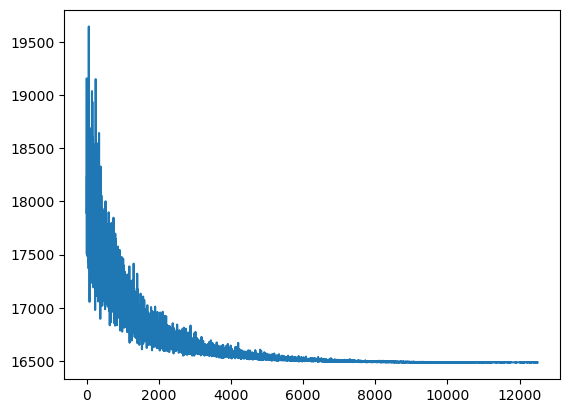

In [59]:
sns.lineplot(pnbd_advi.approx.hist)

## Visual comparison

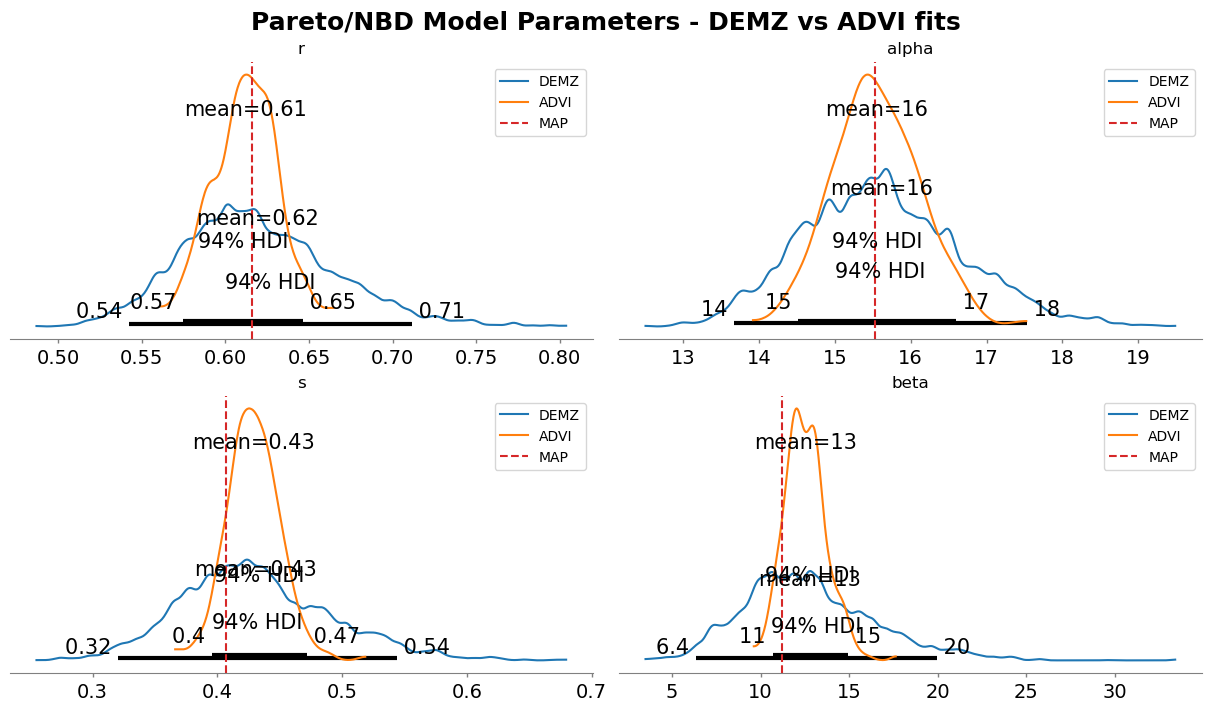

In [62]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    az.plot_posterior(
        pnbd_advi.idata.posterior[var_name].values.flatten(),
        color="C1",
        point_estimate="mean",
        ax=ax,
        label="ADVI",
    )
    # az.plot_posterior(
    #     pnbd_fullrank.idata.posterior[var_name].values.flatten(),
    #     color="C2",
    #     point_estimate="mean",
    #     ax=ax,
    #     label="FULLRANK_ADVI",
    # )
    ax.axvline(x=map_fit[var_name], color="C3", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters - DEMZ vs ADVI fits", fontsize=18, fontweight="bold");

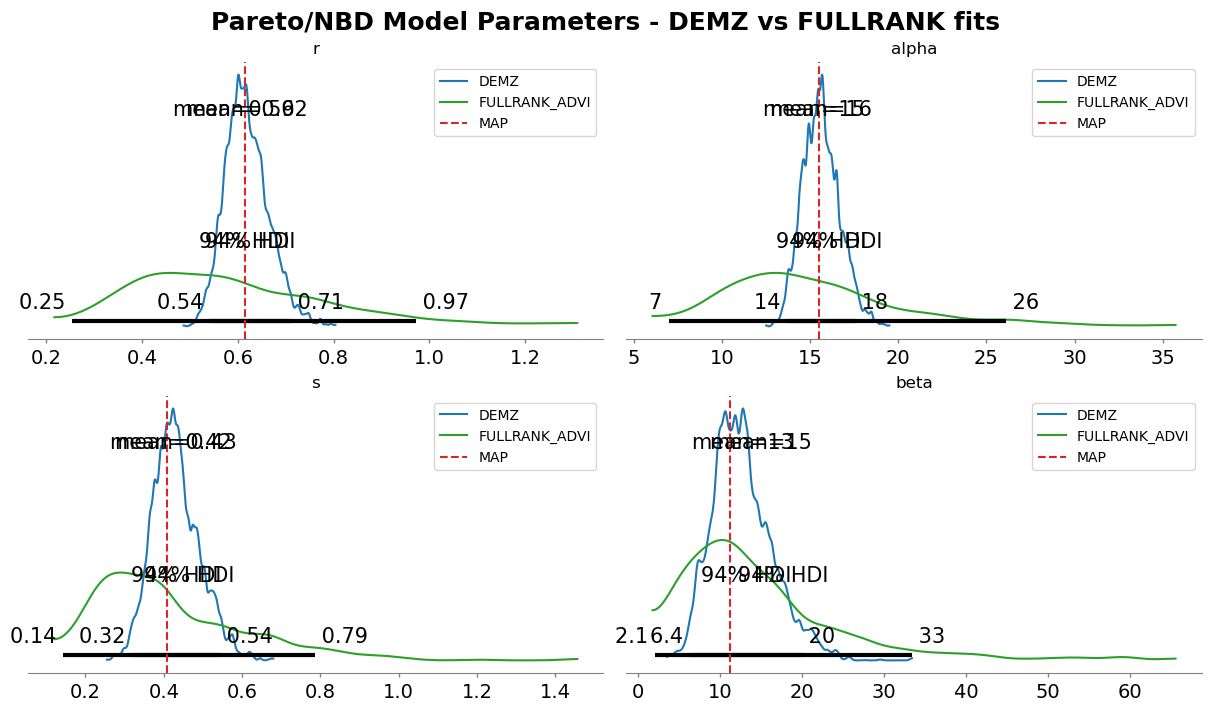

In [64]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    # az.plot_posterior(
    #     pnbd_advi.idata.posterior[var_name].values.flatten(),
    #     color="C1",
    #     point_estimate="mean",
    #     ax=ax,
    #     label="ADVI",
    # )
    az.plot_posterior(
        pnbd_fullrank.idata.posterior[var_name].values.flatten(),
        color="C2",
        point_estimate="mean",
        ax=ax,
        label="FULLRANK_ADVI",
    )
    ax.axvline(x=map_fit[var_name], color="C3", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters - DEMZ vs FULLRANK fits", fontsize=18, fontweight="bold");

Observations:
- Fullrank provides a rather poor fit
- advi's fit does match mcmc, although providing narrower estimates


## Relative Differences in param estimates

In [91]:
(
    100*(pnbd_full.fit_summary()[['mean', 'sd']] - pnbd_advi.fit_summary()[['mean', 'sd']]) / 
    pnbd_full.fit_summary()[['mean', 'sd']]
    ).rename(
    columns={
        "mean": "pcnt_relative_diff_param_mean",
        "sd": "pcnt_relative_diff_param_sd",
    }
)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,pcnt_relative_diff_param_mean,pcnt_relative_diff_param_sd
alpha,0.429102,46.000000
beta,1.717647,68.572203
r,1.130856,58.695652
s,0.464037,65.000000
